<a href="https://colab.research.google.com/github/brianzhang9/Multivariate-time-series-forecasting-using-LSTM/blob/main/%E2%80%9C%E2%80%9CValue%E5%88%86%E6%9E%90_%E6%96%B0%E7%AE%97%E7%9A%84%E5%93%8D%E5%BA%94_8_17_%E5%8E%BB%E6%8E%89%E4%BA%86%E5%89%8D%E4%B8%A4%E6%AD%A5_h2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#加载对应的库
import tensorflow as tf
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional,Dropout,BatchNormalization
from keras.optimizers import adam_v2
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
import os
import random
def seed_tensorflow(seed=44):
  os.environ['PYTHONHASHSEED'] = str(seed) 
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # `pip install tensorflow-determinism` first,使用与tf>2.1
seed_tensorflow(44)

In [ ]:
# 创建训练优化器，如果loss已经收敛就早点停止
early_stopping = EarlyStopping(monitor="val_keras_r2_score",patience=200,mode="max",restore_best_weights=True)

In [ ]:
# 计算R2分数，用来评价模型
def keras_r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [ ]:
# 加载数据
data = pd.read_csv("计算结果-滤波后-完整(响应)-新差分2.csv")
data

,timestamp,Rz,Rg,Uc,Fri,Miu,h1-p,h1-b,h2-p,h2-b,z1-p,z1-b,z2-p,z2-b
0,0.36,0.000000,0.000000,0.000000,0.015652,0.000831,-0.000025,-0.000934,0.000013,-0.000030,0.000369,-0.000586,0.000232,-0.000302
1,0.48,0.000000,0.000000,0.000000,0.028614,0.000635,-0.000004,-0.000568,-0.000090,-0.000129,0.000515,-0.000731,0.000038,-0.000344
2,0.60,0.000000,0.000000,0.000000,0.012329,0.000701,-0.000004,-0.000191,-0.000052,-0.000072,0.000274,-0.000476,0.000099,-0.000266
3,0.72,0.000000,0.000000,0.000000,0.018285,0.000468,0.000015,-0.000461,-0.000058,-0.000071,0.000319,-0.000497,0.000028,-0.000357
4,0.84,0.000000,0.000000,0.000000,0.020216,0.000320,0.000037,-0.000638,-0.000132,-0.000119,0.000281,-0.000482,0.000029,-0.000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,119.04,0.026442,-0.004226,0.009653,0.002468,0.000030,-0.000007,-0.000003,-0.000060,-0.000040,0.000082,-0.000034,-0.000027,-0.000077
990,119.16,-0.027272,-0.043435,-0.008328,-0.003570,0.000011,0.000002,0.000002,0.000089,0.000040,-0.000133,0.000058,0.000099,0.000053
991,119.28,0.051794,-0.032891,0.017196,0.001694,0.000130,-0.000004,-0.000009,-0.000043,-0.000036,0.000052,-0.000013,-0.000091,-0.000042
992,119.40,0.051535,-0.078209,0.011716,-0.001355,0.000199,0.000026,-0.000003,0.000018,0.000019,-0.000016,0.000022,-0.000100,0.000247


In [ ]:
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  994 non-null    float64
 1   Rz         994 non-null    float64
 2   Rg         994 non-null    float64
 3   Uc         994 non-null    float64
 4   Fri        994 non-null    float64
 5   Miu        994 non-null    float64
 6   h1-p       994 non-null    float64
 7   h1-b       994 non-null    float64
 8   h2-p       994 non-null    float64
 9   h2-b       994 non-null    float64
 10  z1-p       994 non-null    float64
 11  z1-b       994 non-null    float64
 12  z2-p       994 non-null    float64
 13  z2-b       994 non-null    float64
dtypes: float64(14)
memory usage: 108.8 KB


In [ ]:
# 加载划分训练集测试集的数据
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
feature_cols = ["Uc","Rg","Rz","Fri","Miu"]
target_col = "h2-b"

In [ ]:
# 处理模型输入和输出
features = data.loc[:,feature_cols].values
targets = data.loc[:,target_col].values[:,np.newaxis]

In [ ]:
# 划分训练集和测试集合，这里不随机打乱，后续要计算根据时间的特征表现
X_train, X_test, y_train, y_test = train_test_split(features,targets,test_size=0.2,shuffle=False)

In [ ]:
# 对数据进行归一化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)[:,np.newaxis,:]
X_test = scaler.transform(X_test)[:,np.newaxis,:]
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
# 创建模型
model = Sequential()
model.add(LSTM(400, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(100, input_shape=(X_train.shape[1:5])))

model.add(BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
optimizer = adam_v2.Adam(learning_rate=1e-2)
model.compile(loss='mse',  optimizer = optimizer,metrics=['mse',keras_r2_score])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 400)               649600    
                                                                 
 batch_normalization_2 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)                25664     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 681,089
Trainable params: 680,289
Non-trainable params: 800
______________________________________________

In [ ]:
# 训练模型
history = model.fit(X_train,y_train,batch_size=128,epochs=1000,validation_data=(X_test,y_test),callbacks=[early_stopping])

Epoch 1/1000
7/7 [==============================] - 3s 130ms/step - loss: 1.4373 - mse: 1.4373 - keras_r2_score: -0.4556 - val_loss: 0.7049 - val_mse: 0.7049 - val_keras_r2_score: 0.0028
Epoch 2/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.6336 - mse: 0.6336 - keras_r2_score: 0.3555 - val_loss: 0.7013 - val_mse: 0.7013 - val_keras_r2_score: 0.0090
Epoch 3/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.4689 - mse: 0.4689 - keras_r2_score: 0.5362 - val_loss: 0.6886 - val_mse: 0.6886 - val_keras_r2_score: 0.0275
Epoch 4/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.4260 - mse: 0.4260 - keras_r2_score: 0.5805 - val_loss: 0.6802 - val_mse: 0.6802 - val_keras_r2_score: 0.0408
Epoch 5/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.2836 - mse: 0.2836 - keras_r2_score: 0.7033 - val_loss: 0.6771 - val_mse: 0.6771 - val_keras_r2_score: 0.0444
Epoch 6/1000
7/7 [==============================] - 0s 29ms/step - loss: 

In [ ]:
# 画结果图
def plot(data,mode="all"):
    if mode == "all":
        test_data = data
    elif mode == "train":
        test_data = data.iloc[:int(0.8 * len(data)),:]
    elif mode == "test":
        test_data = data.iloc[int(0.8 * len(data)):,:]
    test_features = test_data.loc[:,feature_cols].values
    test_targets = test_data.loc[:,target_col].values[:,np.newaxis]
    pred = model.predict(scaler.transform(test_features)[:,np.newaxis,:])
    true = y_scaler.transform(test_targets)
    pred = y_scaler.inverse_transform(pred)
    true = y_scaler.inverse_transform(true)
    print(r2_score(true,pred))
    plt.figure(figsize=(6,3))
    plt.plot(true,label="true value")
    plt.plot(pred,label="pred value")
    plt.legend()
    plt.savefig('pre.svg',format='svg',dpi=150)
    plt.show()

0.7751243132778297


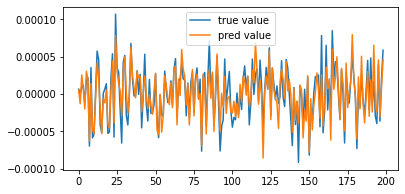

In [ ]:
fig = plot(data,mode="test")

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 定义模型的预测方式
import shap
def f(X):
    # return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return model.predict(np.expand_dims(X, 1)).flatten()

In [ ]:
# 计算对应的shap值
features = scaler.transform(features)
input_X = features
explainer = shap.KernelExplainer(f, input_X.squeeze())
shap_values = explainer.shap_values(input_X, nsamples=500)

  0%|          | 0/994 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,data.loc[:,feature_cols])
#fig = shap.force_plot(explainer.expected_value, shap_values,data.loc[:,feature_cols])
#shap.plots.force(explainer.expected_value, shap_values,data.loc[:,feature_cols], show=False, matplotlib=True).savefig('shap1.svg')
#plt.savefig('shap.svg',format='svg',dpi=1000)

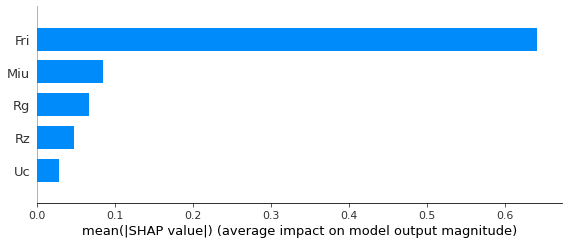

In [ ]:
shap.initjs()
fig = shap.summary_plot(shap_values, data.loc[:,feature_cols], plot_type='bar', show=False)
plt.savefig('shap.svg',format='svg',dpi=150)

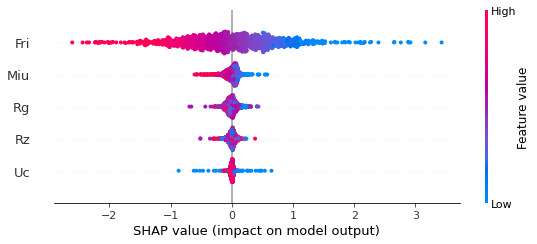

In [ ]:
shap.initjs()
fig = shap.summary_plot(shap_values, data.loc[:,feature_cols], show=False)
plt.savefig('shap2.svg',format='svg',dpi=150)

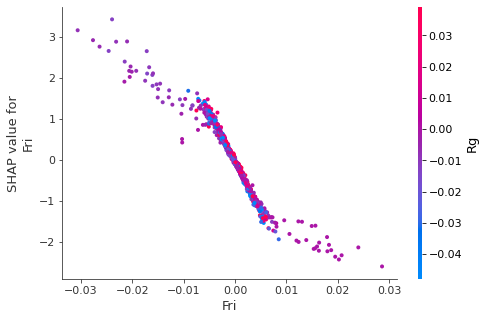

In [ ]:
shap.initjs()
shap.dependence_plot("Fri", shap_values, data.loc[:,feature_cols])